# Introduction
This notebook analyzes cleaned data in order to understand the relationship between temperature and kelp growth in the Salish Sea

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data

In [2]:
path = "https://raw.githubusercontent.com/sgolden3/Data-5100-Kelp/refs/heads/main/Data/cleaned_data/"

df = pd.read_csv("https://raw.githubusercontent.com/sgolden3/Data-5100-Kelp/refs/heads/main/Data/cleaned_data/AllBeds_Clean.csv")

## Make one consolidated temperature column

### Define temp columns

### Temperature function

In [3]:
def fill_temperature(df):
    """
    Fills a new temperature column 'Temp_Final' using the following logic:

    1. If Temp exists → use Temp
    2. Else:
        a. If both Ave Temp Shore Edge and Ave Temp Water Edge exist:
              (Ave Temp Shore Edge + Ave Temp Water Edge) / 2
        b. Else:
              ((Temp1 Shore Edge + Temp2 Shore Edge)/2  +
               (Temp1 Water Edge + Temp2 Water Edge)/2) / 2
    """

    df["Temp_Final"] = np.where(
        ~df["Temp"].isna(),                      # Case 1: Temp exists
        df["Temp"],                              # → use Temp

        np.where(
            (~df["Ave Temp Shore Edge"].isna()) &
            (~df["Ave Temp Water Edge"].isna()), # Case 2a: both average temps exist
            (df["Ave Temp Shore Edge"] + df["Ave Temp Water Edge"]) / 2,

            # Case 2b: fallback using Temp1/Temp2 averages
            (
                ((df["Temp1 Shore Edge"] + df["Temp2 Shore Edge"]) / 2) +
                ((df["Temp1 Water Edge"] + df["Temp2 Water Edge"]) / 2)
            ) / 2
        )
    )

    return df

In [4]:
temp_cols = ["Temp1 Shore Edge","Temp2 Shore Edge","Temp1 Water Edge","Temp2 Water Edge"]
df[temp_cols] = df[temp_cols].apply(pd.to_numeric, errors="coerce")
df = fill_temperature(df)

In [5]:
temp_cols_all = [
    'Temp', 'Temp1 Shore Edge', 'Temp1 Water Edge',
    'Temp2 Shore Edge', 'Temp2 Water Edge',
    'Ave Temp Shore Edge', 'Ave Temp Water Edge']

all_nan_rows = df[df[temp_cols_all].isnull().all(axis=1)]
all_nan_rows.shape

(28, 16)

### Find Historical Temps

### Restrict to only NWSC 1 columns

Create a Pct Change columns

In [6]:
# 1. Select Max Extent only
df_max = (df[df["NWSC Max Ext"] == 1]
.sort_values(["Site Code", "Survey Year", "Acres"],
       ascending=[True, True, False])
.drop_duplicates(subset=["Site Code", "Survey Year"], keep="first")
.copy()
)

df_max["PctAcreChange"] = (
df_max.groupby("Site Code")["Acres"]
.pct_change()
* 100
)


### Make a function to find hisotrical temperatures

In [7]:
# Convert 'Survey Date' to datetime for DateOffset operations
df_max['Survey Date'] = pd.to_datetime(df_max['Survey Date'])

In [8]:
def get_historical_temperatures(row, df_search):
    """
    Finds historical temperatures for the same site code, month, and day in previous years.

    Args:
        row (pd.Series): A row from the DataFrame (df_max) containing 'Survey Date' and 'Site Code'.
        df_search (pd.DataFrame): The DataFrame to search for historical temperatures (e.g., df_max itself).

    Returns:
        tuple: (temp_one_year_prior, temp_two_years_prior, temp_three_years_prior, temp_four_years_prior)
               or (pd.NA, pd.NA, pd.NA, pd.NA) if not found.
    """
    current_date = row['Survey Date']
    current_site_code = row['Site Code']

    if pd.isna(current_date):
        return pd.NA, pd.NA, pd.NA, pd.NA

    # Helper to get temperature for a specific date, returning NaN if not found
    def get_temp_for_date_and_site(target_date, site_code_to_match, df_filtered_for_temp):
        # Filter for the exact site code, year, month
        match = df_filtered_for_temp[
            (df_filtered_for_temp['Site Code'] == site_code_to_match) &
            (df_filtered_for_temp['Survey Date'].dt.year == target_date.year)
        ]
        if not match.empty:
            # We are looking for the 'Temp_Final' column which was created earlier
            return match['Temp_Final'].iloc[0]
        return pd.NA

    # Calculate target dates for prior years
    one_year_ago = current_date - pd.DateOffset(years=1)
    two_years_ago = current_date - pd.DateOffset(years=2)
    three_years_ago = current_date - pd.DateOffset(years=3)
    four_years_ago = current_date - pd.DateOffset(years=4)

    temp_one_year_prior = get_temp_for_date_and_site(one_year_ago, current_site_code, df_search)
    temp_two_years_prior = get_temp_for_date_and_site(two_years_ago, current_site_code, df_search)
    temp_three_years_prior = get_temp_for_date_and_site(three_years_ago, current_site_code, df_search)
    temp_four_years_prior = get_temp_for_date_and_site(four_years_ago, current_site_code, df_search)

    return temp_one_year_prior, temp_two_years_prior, temp_three_years_prior, temp_four_years_prior

# Apply the function to df_max
df_max[[
    "Temp_t_minus1", "Temp_t_minus2",
    "Temp_t_minus3", "Temp_t_minus4"
]] = df_max.apply(lambda row: get_historical_temperatures(row, df_max), axis=1, result_type='expand')

print("Function 'get_historical_temperatures' modified and applied successfully.")

Function 'get_historical_temperatures' modified and applied successfully.


In [9]:
df_max.rename(columns={'Temp_Final': 'Temp_t'}, inplace=True)

## Impute missing data

In [10]:
 #2.1 Temp Imputation
temp_cols = ["Temp_t", "Temp_t_minus1", "Temp_t_minus2",
              "Temp_t_minus3", "Temp_t_minus4"]

monthly_avgs = (
    df_max.groupby(["Site Code", "Survey Month"])["Temp_t"]
          .mean()
          .rename("MonthlyTempMean")
)

df_max = df_max.merge(monthly_avgs, on=["Site Code", "Survey Month"], how="left")

for col in temp_cols:
    df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])

/tmp/ipython-input-2525462948.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])


In [11]:
df_max

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
0,Aiston Preserve,AISP,2018-07-31,31.0,1.0,7.0,2018.0,0.117903,16.0,NaN,...,NaN,NaN,NaN,16.000,NaN,15.415,15.415,15.415,15.415,15.4150
1,Aiston Preserve,AISP,2019-08-01,1.0,1.0,8.0,2019.0,0.167167,16.0,NaN,...,NaN,NaN,NaN,16.000,41.783878,16.000,16.000,16.000,16.000,16.0000
2,Aiston Preserve,AISP,2020-07-20,20.0,1.0,7.0,2020.0,0.327542,NaN,15.00,...,15.00,15.30,15.00,15.150,95.936898,16.000,16.000,15.415,15.415,15.4150
3,Aiston Preserve,AISP,2021-07-27,27.0,1.0,7.0,2021.0,0.207529,NaN,14.44,...,14.44,14.44,14.44,14.440,-36.640490,15.150,16.000,16.000,15.415,15.4150
4,Aiston Preserve,AISP,2022-07-31,31.0,1.0,7.0,2022.0,0.296172,NaN,20.00,...,20.00,20.00,20.00,20.000,42.713633,14.440,15.150,16.000,16.000,15.4150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Shannon Point West,SHPT-W,2020-09-18,18.0,1.0,9.0,2020.0,7.790410,NaN,11.30,...,NaN,11.30,11.50,11.400,76.472068,14.000,16.000,12.000,12.649,12.6490
133,Shannon Point West,SHPT-W,2021-09-19,19.0,1.0,9.0,2021.0,4.860296,NaN,11.11,...,10.56,11.11,10.28,10.695,-37.611814,11.400,14.000,16.000,12.000,12.6490
134,Shannon Point West,SHPT-W,2022-08-12,12.0,1.0,8.0,2022.0,3.267264,NaN,12.78,...,NaN,12.78,11.11,11.945,-32.776441,10.695,11.400,14.000,16.000,12.0725
135,Shannon Point West,SHPT-W,2023-09-01,1.0,1.0,9.0,2023.0,4.720687,NaN,13.30,...,13.30,12.90,13.40,13.150,44.484413,11.945,10.695,11.400,14.000,12.6490


## Make a function to find correlations for all of the beds

In [12]:
def corr_max(df):
  # 3. Predictor list
  predictor_variables = ["Temp_t",
      "Temp_t_minus1", "Temp_t_minus2",
    "Temp_t_minus3", "Temp_t_minus4"
  ]

  # 4. Numerical predictors
  numerical_predictors = (
      df[predictor_variables]
      .select_dtypes(include="number")
      .columns
      .to_list()
  )

  # 5. Correlation matrix with Acres appended
  corr_matrix = df[numerical_predictors + ["Acres", "PctAcreChange"]].corr()

  # Subset of columns to show
  selected_cols = [
      "Site Code", "Survey Day", "Survey Month", "Survey Year",
      "Acres", "Temp_t", "Temp_t_minus1", "Temp_t_minus2",
    "Temp_t_minus3", "Temp_t_minus4", "PctAcreChange"
  ]

  df_selected = df[selected_cols]

  # 6. Heatmap
  sns.heatmap(
      corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
  )
  plt.tick_params(labelsize=12)
  plt.title("Max Extent vs Temp Correlation Matrix", fontsize=14)
  plt.show()

  df_selected
  return df_selected

###Site codes

In [13]:
df_max['Site Code'].unique()

array(['AISP', 'BZPT', 'BZPT-S', 'CHPT', 'CLLB', 'COFF', 'EBL', 'FWB',
       'FWBO', 'HAT-S', 'HOYP', 'LMMI-SW', 'LWLP', 'NB-E', 'POLN', 'POSS',
       'SHPT-E', 'SHPT-W'], dtype=object)

## Correlation Matrices

### All beds

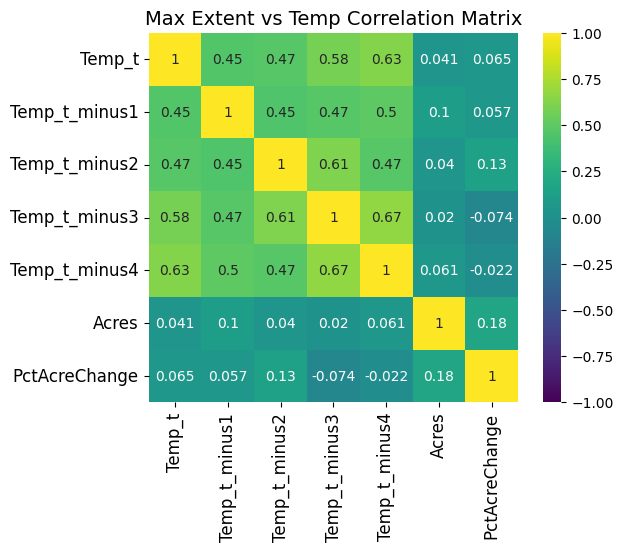

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
0,AISP,31.0,7.0,2018.0,0.117903,16.000,15.415,15.415,15.415,15.415,NaN
1,AISP,1.0,8.0,2019.0,0.167167,16.000,16.000,16.000,16.000,16.000,41.783878
2,AISP,20.0,7.0,2020.0,0.327542,15.150,16.000,16.000,15.415,15.415,95.936898
3,AISP,27.0,7.0,2021.0,0.207529,14.440,15.150,16.000,16.000,15.415,-36.640490
4,AISP,31.0,7.0,2022.0,0.296172,20.000,14.440,15.150,16.000,16.000,42.713633
...,...,...,...,...,...,...,...,...,...,...,...
132,SHPT-W,18.0,9.0,2020.0,7.790410,11.400,14.000,16.000,12.000,12.649,76.472068
133,SHPT-W,19.0,9.0,2021.0,4.860296,10.695,11.400,14.000,16.000,12.000,-37.611814
134,SHPT-W,12.0,8.0,2022.0,3.267264,11.945,10.695,11.400,14.000,16.000,-32.776441
135,SHPT-W,1.0,9.0,2023.0,4.720687,13.150,11.945,10.695,11.400,14.000,44.484413


In [14]:
corr_max(df_max)

### Ebey

In [15]:
ebey = df_max[df_max['Site Code']== 'EBL']
ebey

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
39,Ebey's Landing,EBL,2015-08-15,15.0,1.0,8.0,2015.0,18.354044,13.0,NaN,...,NaN,NaN,NaN,13.00,NaN,12.18125,12.18125,12.18125,12.18125,12.18125
40,Ebey's Landing,EBL,2016-07-22,22.0,1.0,7.0,2016.0,20.396699,12.0,NaN,...,NaN,NaN,NaN,12.00,11.129181,13.00000,12.00000,12.00000,12.00000,12.00000
41,Ebey's Landing,EBL,2017-09-16,16.0,1.0,9.0,2017.0,21.534815,11.0,NaN,...,NaN,NaN,NaN,11.00,5.579906,12.00000,13.00000,11.00000,11.00000,11.00000
42,Ebey's Landing,EBL,2018-08-07,7.0,1.0,8.0,2018.0,21.293413,12.0,NaN,...,NaN,NaN,NaN,12.00,-1.120989,11.00000,12.00000,13.00000,12.18125,12.18125
43,Ebey's Landing,EBL,2019-08-13,13.0,1.0,8.0,2019.0,41.131154,13.0,NaN,...,12.7,NaN,NaN,13.00,93.163749,12.00000,11.00000,12.00000,13.00000,12.18125
44,Ebey's Landing,EBL,2020-08-30,30.0,1.0,8.0,2020.0,41.614620,NaN,11.9,...,NaN,11.90,12.00,11.95,1.175426,13.00000,12.00000,11.00000,12.00000,12.18125
45,Ebey's Landing,EBL,2021-08-11,11.0,1.0,8.0,2021.0,37.681341,NaN,12.0,...,NaN,12.00,12.00,12.00,-9.451676,11.95000,13.00000,12.00000,11.00000,12.18125
46,Ebey's Landing,EBL,2022-08-23,23.0,1.0,8.0,2022.0,38.629817,NaN,11.9,...,12.2,12.05,12.25,12.15,2.517096,12.00000,11.95000,13.00000,12.00000,12.18125
47,Ebey's Landing,EBL,2023-08-14,14.0,1.0,8.0,2023.0,31.122627,NaN,11.8,...,12.2,11.80,12.20,12.00,-19.433665,12.15000,12.00000,11.95000,13.00000,12.18125
48,Ebey's Landing,EBL,2024-08-20,20.0,1.0,8.0,2024.0,33.207906,NaN,11.0,...,11.4,11.40,11.30,11.35,6.700200,12.00000,12.15000,12.00000,11.95000,12.18125


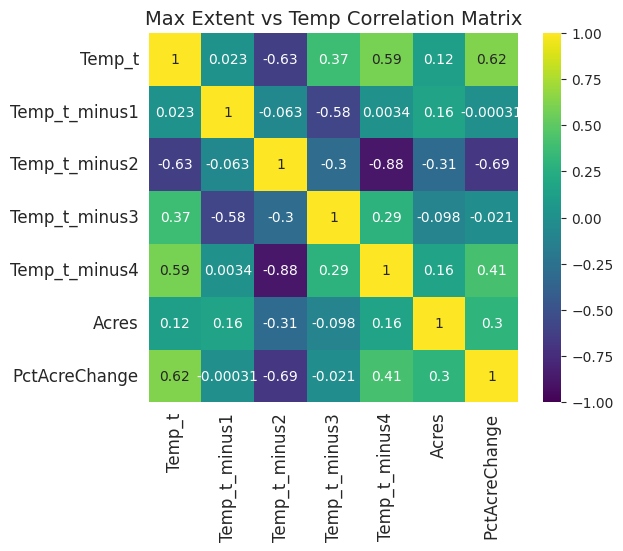

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
39,EBL,15.0,8.0,2015.0,18.354044,13.00,12.18125,12.18125,12.18125,12.18125,NaN
40,EBL,22.0,7.0,2016.0,20.396699,12.00,13.00000,12.00000,12.00000,12.00000,11.129181
41,EBL,16.0,9.0,2017.0,21.534815,11.00,12.00000,13.00000,11.00000,11.00000,5.579906
42,EBL,7.0,8.0,2018.0,21.293413,12.00,11.00000,12.00000,13.00000,12.18125,-1.120989
43,EBL,13.0,8.0,2019.0,41.131154,13.00,12.00000,11.00000,12.00000,13.00000,93.163749
44,EBL,30.0,8.0,2020.0,41.614620,11.95,13.00000,12.00000,11.00000,12.00000,1.175426
45,EBL,11.0,8.0,2021.0,37.681341,12.00,11.95000,13.00000,12.00000,11.00000,-9.451676
46,EBL,23.0,8.0,2022.0,38.629817,12.15,12.00000,11.95000,13.00000,12.00000,2.517096
47,EBL,14.0,8.0,2023.0,31.122627,12.00,12.15000,12.00000,11.95000,13.00000,-19.433665
48,EBL,20.0,8.0,2024.0,33.207906,11.35,12.00000,12.15000,12.00000,11.95000,6.700200


In [73]:
ebey_clean = corr_max(ebey)
ebey_clean

Strongest correlation was temp t minus 2 at -0.69

### Possession Point

In [18]:
poss = df_max[df_max['Site Code']== 'POSS']
poss

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
113,Possession Point,POSS,2017-08-24,24.0,1.0,8.0,2017.0,21.484920,13.0,NaN,...,NaN,NaN,NaN,13.000,NaN,15.382143,15.382143,15.382143,15.382143,15.382143
114,Possession Point,POSS,2018-08-14,14.0,1.0,8.0,2018.0,38.002331,16.0,NaN,...,NaN,NaN,NaN,16.000,76.879088,13.000000,15.382143,15.382143,15.382143,15.382143
115,Possession Point,POSS,2019-08-16,16.0,1.0,8.0,2019.0,60.670912,15.0,NaN,...,NaN,NaN,NaN,15.000,59.650501,16.000000,13.000000,15.382143,15.382143,15.382143
116,Possession Point,POSS,2020-08-31,31.0,1.0,8.0,2020.0,51.085699,NaN,15.0,...,NaN,15.00,14.50,14.750,-15.798696,15.000000,16.000000,13.000000,15.382143,15.382143
117,Possession Point,POSS,2021-08-11,11.0,1.0,8.0,2021.0,65.733887,NaN,16.0,...,18.0,16.00,17.50,16.750,28.673755,14.750000,15.000000,16.000000,13.000000,15.382143
118,Possession Point,POSS,2022-09-10,10.0,1.0,9.0,2022.0,88.630361,NaN,14.5,...,14.5,14.25,14.25,14.250,34.832071,16.750000,14.750000,15.000000,16.000000,14.250000
119,Possession Point,POSS,2023-08-14,14.0,1.0,8.0,2023.0,85.887200,NaN,16.8,...,18.6,17.00,17.60,17.300,-3.095059,14.250000,16.750000,14.750000,15.000000,15.382143
120,Possession Point,POSS,2024-08-16,16.0,1.0,8.0,2024.0,75.564707,NaN,14.8,...,14.8,15.05,14.70,14.875,-12.018662,17.300000,14.250000,16.750000,14.750000,15.382143


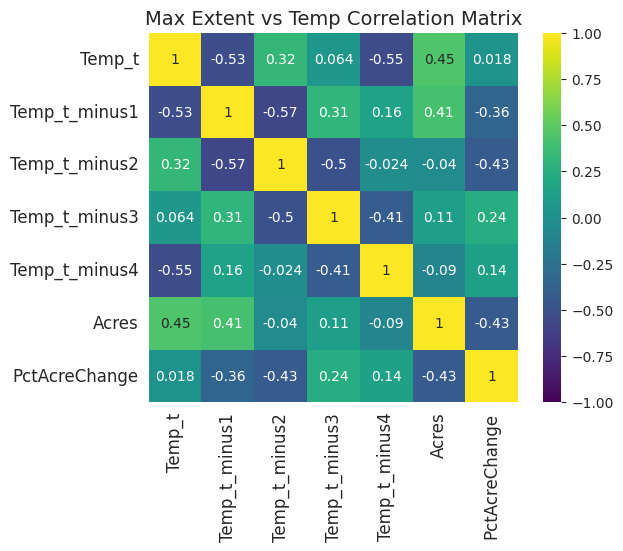

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
113,POSS,24.0,8.0,2017.0,21.484920,13.000,15.382143,15.382143,15.382143,15.382143,NaN
114,POSS,14.0,8.0,2018.0,38.002331,16.000,13.000000,15.382143,15.382143,15.382143,76.879088
115,POSS,16.0,8.0,2019.0,60.670912,15.000,16.000000,13.000000,15.382143,15.382143,59.650501
116,POSS,31.0,8.0,2020.0,51.085699,14.750,15.000000,16.000000,13.000000,15.382143,-15.798696
117,POSS,11.0,8.0,2021.0,65.733887,16.750,14.750000,15.000000,16.000000,13.000000,28.673755
118,POSS,10.0,9.0,2022.0,88.630361,14.250,16.750000,14.750000,15.000000,16.000000,34.832071
119,POSS,14.0,8.0,2023.0,85.887200,17.300,14.250000,16.750000,14.750000,15.000000,-3.095059
120,POSS,16.0,8.0,2024.0,75.564707,14.875,17.300000,14.250000,16.750000,14.750000,-12.018662


In [76]:
possession_clean = corr_max(poss)
possession_clean

Strongest correlation was -0.43 for temperature minus 2

### Polnell

In [20]:
polnell = df_max[df_max['Site Code']== 'POLN']
polnell

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
104,Polnell Point,POLN,2016-08-30,30.0,1.0,8.0,2016.0,36.728040,17.0,NaN,...,NaN,NaN,NaN,17.000,NaN,14.795,14.795,14.795,14.795,14.795
105,Polnell Point,POLN,2017-09-18,18.0,1.0,9.0,2017.0,27.432119,NaN,NaN,...,NaN,NaN,NaN,13.700,-25.310147,17.000,13.700,13.700,13.700,13.700
106,Polnell Point,POLN,2018-09-10,10.0,1.0,9.0,2018.0,75.709687,13.0,NaN,...,NaN,NaN,NaN,13.000,175.989204,13.700,17.000,13.700,13.700,13.700
107,Polnell Point,POLN,2019-09-26,26.0,1.0,9.0,2019.0,47.312350,15.0,NaN,...,NaN,NaN,NaN,15.000,-37.508195,13.000,13.700,17.000,13.700,13.700
108,Polnell Point,POLN,2020-08-31,31.0,1.0,8.0,2020.0,41.303716,NaN,13.9,...,NaN,13.90,13.2,13.550,-12.699927,15.000,13.000,14.795,17.000,14.795
109,Polnell Point,POLN,2021-08-24,24.0,1.0,8.0,2021.0,36.426616,NaN,13.6,...,13.9,13.60,13.8,13.700,-11.807897,13.550,15.000,13.000,14.795,14.795
110,Polnell Point,POLN,2022-09-11,11.0,1.0,9.0,2022.0,17.561865,NaN,13.2,...,12.9,13.20,13.0,13.100,-51.788371,13.700,13.550,15.000,13.000,13.700
111,Polnell Point,POLN,2023-08-15,15.0,1.0,8.0,2023.0,38.712918,NaN,14.9,...,14.8,15.50,15.4,15.450,120.437399,13.100,13.700,13.550,15.000,14.795
112,Polnell Point,POLN,2024-08-21,21.0,1.0,8.0,2024.0,35.730997,NaN,14.5,...,14.1,14.15,14.4,14.275,-7.702650,15.450,13.100,13.700,13.550,14.795


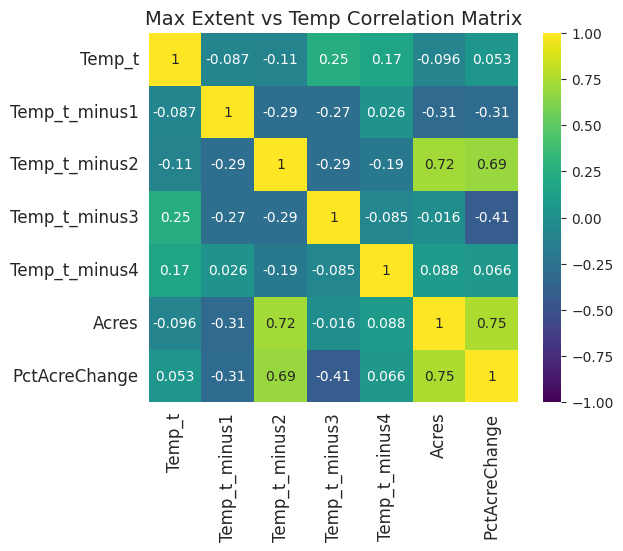

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
104,POLN,30.0,8.0,2016.0,36.728040,17.000,14.795,14.795,14.795,14.795,NaN
105,POLN,18.0,9.0,2017.0,27.432119,13.700,17.000,13.700,13.700,13.700,-25.310147
106,POLN,10.0,9.0,2018.0,75.709687,13.000,13.700,17.000,13.700,13.700,175.989204
107,POLN,26.0,9.0,2019.0,47.312350,15.000,13.000,13.700,17.000,13.700,-37.508195
108,POLN,31.0,8.0,2020.0,41.303716,13.550,15.000,13.000,14.795,17.000,-12.699927
109,POLN,24.0,8.0,2021.0,36.426616,13.700,13.550,15.000,13.000,14.795,-11.807897
110,POLN,11.0,9.0,2022.0,17.561865,13.100,13.700,13.550,15.000,13.000,-51.788371
111,POLN,15.0,8.0,2023.0,38.712918,15.450,13.100,13.700,13.550,15.000,120.437399
112,POLN,21.0,8.0,2024.0,35.730997,14.275,15.450,13.100,13.700,13.550,-7.702650


In [82]:
polnell_clean = corr_max(polnell)
polnell_clean

Strongest correlation was 0.69 for temperature minus 2

### North Beach

In [22]:
nobo = df_max[df_max['Site Code']== 'NB-E']
nobo

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
95,North Beach East,NB-E,2016-09-22,22.0,1.0,9.0,2016.0,22.091116,13.0,NaN,...,NaN,NaN,NaN,13.0000,NaN,13.0000,13.0000,13.0000,13.0000,13.0000
96,North Beach East,NB-E,2017-07-22,22.0,1.0,7.0,2017.0,18.515317,11.0,NaN,...,NaN,NaN,NaN,11.0000,-16.186594,13.0000,11.0000,11.0000,11.0000,11.0000
97,North Beach East,NB-E,2018-08-25,25.0,1.0,8.0,2018.0,9.329159,NaN,NaN,...,NaN,NaN,NaN,12.2125,-49.613831,11.0000,13.0000,12.2125,12.2125,12.2125
98,North Beach East,NB-E,2019-09-02,2.0,1.0,9.0,2019.0,11.850943,13.0,NaN,...,NaN,NaN,NaN,13.0000,27.031207,13.0000,11.0000,13.0000,13.0000,13.0000
99,North Beach East,NB-E,2020-08-26,26.0,1.0,8.0,2020.0,14.853054,NaN,14.0,...,NaN,14.00,14.00,14.0000,25.332255,13.0000,12.2125,11.0000,13.0000,12.2125
100,North Beach East,NB-E,2021-08-20,20.0,1.0,8.0,2021.0,25.579078,NaN,12.1,...,NaN,12.10,NaN,12.2125,72.214270,14.0000,13.0000,12.2125,11.0000,12.2125
101,North Beach East,NB-E,2022-08-27,27.0,1.0,8.0,2022.0,19.145410,NaN,11.8,...,11.6,11.65,11.55,11.6000,-25.152071,12.2125,14.0000,13.0000,12.2125,12.2125
102,North Beach East,NB-E,2023-08-12,12.0,1.0,8.0,2023.0,18.188146,NaN,11.8,...,11.8,12.00,11.80,11.9000,-4.999968,11.6000,12.2125,14.0000,13.0000,12.2125
103,North Beach East,NB-E,2024-08-17,17.0,1.0,8.0,2024.0,19.296391,NaN,NaN,...,10.9,11.80,10.90,11.3500,6.093229,11.9000,11.6000,12.2125,14.0000,12.2125


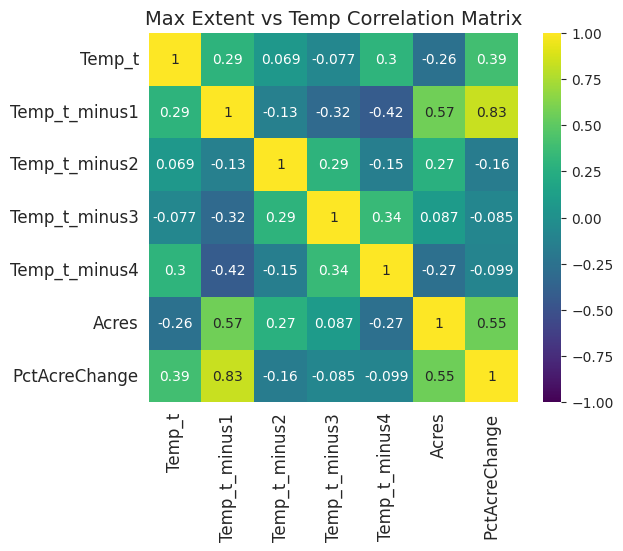

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
95,NB-E,22.0,9.0,2016.0,22.091116,13.0000,13.0000,13.0000,13.0000,13.0000,NaN
96,NB-E,22.0,7.0,2017.0,18.515317,11.0000,13.0000,11.0000,11.0000,11.0000,-16.186594
97,NB-E,25.0,8.0,2018.0,9.329159,12.2125,11.0000,13.0000,12.2125,12.2125,-49.613831
98,NB-E,2.0,9.0,2019.0,11.850943,13.0000,13.0000,11.0000,13.0000,13.0000,27.031207
99,NB-E,26.0,8.0,2020.0,14.853054,14.0000,13.0000,12.2125,11.0000,13.0000,25.332255
100,NB-E,20.0,8.0,2021.0,25.579078,12.2125,14.0000,13.0000,12.2125,11.0000,72.214270
101,NB-E,27.0,8.0,2022.0,19.145410,11.6000,12.2125,14.0000,13.0000,12.2125,-25.152071
102,NB-E,12.0,8.0,2023.0,18.188146,11.9000,11.6000,12.2125,14.0000,13.0000,-4.999968
103,NB-E,17.0,8.0,2024.0,19.296391,11.3500,11.9000,11.6000,12.2125,14.0000,6.093229


In [88]:
north_clean = corr_max(nobo)
north_clean

Strongest correlation was temp T minus 1 at 0.83

###Hoypus Point

In [24]:
hoypus = df_max[df_max['Site Code']== 'HOYP']
hoypus

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
74,Hoypus Point,HOYP,2016-08-19,19.0,1.0,8.0,2016.0,3.712156,14.0,NaN,...,NaN,NaN,NaN,14.000,NaN,13.675,13.6750,13.6750,13.6750,13.6750
75,Hoypus Point,HOYP,2017-07-25,25.0,1.0,7.0,2017.0,3.605778,10.0,NaN,...,NaN,NaN,NaN,10.000,-2.865681,14.000,11.5125,11.5125,11.5125,11.5125
76,Hoypus Point,HOYP,2021-09-06,6.0,1.0,9.0,2021.0,2.128078,NaN,16.0,...,NaN,16.00,14.00,15.000,-40.981437,15.000,15.0000,15.0000,10.0000,15.0000
77,Hoypus Point,HOYP,2022-07-18,18.0,1.0,7.0,2022.0,3.944428,NaN,13.0,...,13.2,13.05,13.00,13.025,85.351647,15.000,11.5125,11.5125,11.5125,11.5125
78,Hoypus Point,HOYP,2023-08-15,15.0,1.0,8.0,2023.0,3.468347,NaN,14.5,...,13.4,14.70,13.70,14.200,-12.069707,13.025,15.0000,13.6750,13.6750,13.6750
79,Hoypus Point,HOYP,2024-08-16,16.0,1.0,8.0,2024.0,3.406280,NaN,12.8,...,12.7,12.80,12.85,12.825,-1.789522,14.200,13.0250,15.0000,13.6750,13.6750


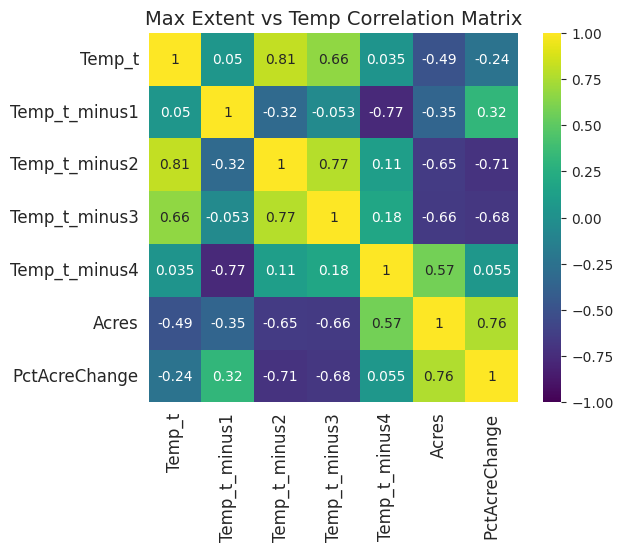

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
74,HOYP,19.0,8.0,2016.0,3.712156,14.000,13.675,13.6750,13.6750,13.6750,NaN
75,HOYP,25.0,7.0,2017.0,3.605778,10.000,14.000,11.5125,11.5125,11.5125,-2.865681
76,HOYP,6.0,9.0,2021.0,2.128078,15.000,15.000,15.0000,15.0000,10.0000,-40.981437
77,HOYP,18.0,7.0,2022.0,3.944428,13.025,15.000,11.5125,11.5125,11.5125,85.351647
78,HOYP,15.0,8.0,2023.0,3.468347,14.200,13.025,15.0000,13.6750,13.6750,-12.069707
79,HOYP,16.0,8.0,2024.0,3.406280,12.825,14.200,13.0250,15.0000,13.6750,-1.789522


In [92]:
hoypus_clean = corr_max(hoypus)
hoypus_clean

Strongest correlation was temp t minus two at -0.71. Temp t minus three was also a strong correlation at -0.68

In [26]:
print(f"Number of rows assessed for correlation in Hoypus Point: {len(hoypus)}")

Number of rows assessed for correlation in Hoypus Point: 6


###Shannon Point East

In [42]:
shannon_east = df_max[df_max['Site Code']== 'SHPT-E']
shannon_east

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
121,Shannon Point East,SHPT-E,2017-09-15,15.0,1.0,9.0,2017.0,8.398104,14.0,NaN,...,NaN,NaN,NaN,14.000,NaN,13.116667,13.116667,13.116667,13.116667,13.116667
122,Shannon Point East,SHPT-E,2018-09-10,10.0,1.0,9.0,2018.0,10.128359,14.0,NaN,...,NaN,NaN,NaN,14.000,20.602937,14.000000,13.116667,13.116667,13.116667,13.116667
123,Shannon Point East,SHPT-E,2019-08-18,18.0,1.0,8.0,2019.0,12.096496,17.0,NaN,...,NaN,NaN,NaN,17.000,19.431941,14.000000,14.000000,13.832500,13.832500,13.832500
124,Shannon Point East,SHPT-E,2020-09-18,18.0,1.0,9.0,2020.0,8.583313,NaN,11.40,...,NaN,11.40,11.30,11.350,-29.042983,17.000000,14.000000,14.000000,13.116667,13.116667
125,Shannon Point East,SHPT-E,2021-08-20,20.0,1.0,8.0,2021.0,8.483059,NaN,13.33,...,NaN,13.33,13.33,13.330,-1.168013,11.350000,17.000000,14.000000,14.000000,13.832500
126,Shannon Point East,SHPT-E,2022-07-01,1.0,1.0,7.0,2022.0,5.374904,NaN,10.56,...,NaN,10.56,11.11,10.835,-36.639547,13.330000,11.350000,17.000000,14.000000,10.835000
127,Shannon Point East,SHPT-E,2023-08-04,4.0,1.0,8.0,2023.0,1.216887,NaN,12.80,...,12.8,12.80,12.80,12.800,-77.359844,10.835000,13.330000,11.350000,17.000000,13.832500
128,Shannon Point East,SHPT-E,2024-08-16,16.0,1.0,8.0,2024.0,0.390402,NaN,12.20,...,12.2,12.20,12.20,12.200,-67.918008,12.800000,10.835000,13.330000,11.350000,13.832500


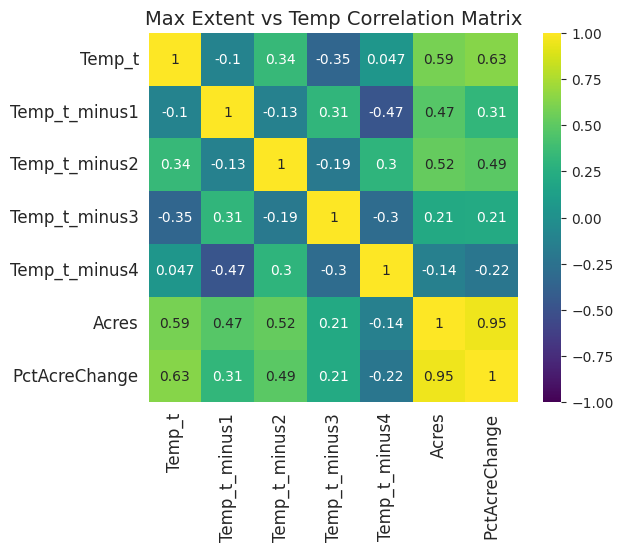

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
121,SHPT-E,15.0,9.0,2017.0,8.398104,14.000,13.116667,13.116667,13.116667,13.116667,NaN
122,SHPT-E,10.0,9.0,2018.0,10.128359,14.000,14.000000,13.116667,13.116667,13.116667,20.602937
123,SHPT-E,18.0,8.0,2019.0,12.096496,17.000,14.000000,14.000000,13.832500,13.832500,19.431941
124,SHPT-E,18.0,9.0,2020.0,8.583313,11.350,17.000000,14.000000,14.000000,13.116667,-29.042983
125,SHPT-E,20.0,8.0,2021.0,8.483059,13.330,11.350000,17.000000,14.000000,14.000000,-1.168013
126,SHPT-E,1.0,7.0,2022.0,5.374904,10.835,13.330000,11.350000,17.000000,14.000000,-36.639547
127,SHPT-E,4.0,8.0,2023.0,1.216887,12.800,10.835000,13.330000,11.350000,17.000000,-77.359844
128,SHPT-E,16.0,8.0,2024.0,0.390402,12.200,12.800000,10.835000,13.330000,11.350000,-67.918008


In [97]:
shannon_east_clean = corr_max(shannon_east)
shannon_east_clean

Strongest correlation was Temp t at 0.63

###Shannon Point West

In [44]:
shannon_west = df_max[df_max['Site Code']== 'SHPT-W']
shannon_west

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
129,Shannon Point West,SHPT-W,2017-09-15,15.0,1.0,9.0,2017.0,5.081829,12.0,NaN,...,NaN,NaN,NaN,12.000,NaN,12.649,12.649,12.649,12.649,12.6490
130,Shannon Point West,SHPT-W,2018-09-10,10.0,1.0,9.0,2018.0,9.818176,16.0,NaN,...,NaN,NaN,NaN,16.000,93.201636,12.000,12.649,12.649,12.649,12.6490
131,Shannon Point West,SHPT-W,2019-07-28,28.0,1.0,7.0,2019.0,4.414529,14.0,NaN,...,NaN,NaN,NaN,14.000,-55.037181,16.000,12.000,14.000,14.000,14.0000
132,Shannon Point West,SHPT-W,2020-09-18,18.0,1.0,9.0,2020.0,7.790410,NaN,11.30,...,NaN,11.30,11.50,11.400,76.472068,14.000,16.000,12.000,12.649,12.6490
133,Shannon Point West,SHPT-W,2021-09-19,19.0,1.0,9.0,2021.0,4.860296,NaN,11.11,...,10.56,11.11,10.28,10.695,-37.611814,11.400,14.000,16.000,12.000,12.6490
134,Shannon Point West,SHPT-W,2022-08-12,12.0,1.0,8.0,2022.0,3.267264,NaN,12.78,...,NaN,12.78,11.11,11.945,-32.776441,10.695,11.400,14.000,16.000,12.0725
135,Shannon Point West,SHPT-W,2023-09-01,1.0,1.0,9.0,2023.0,4.720687,NaN,13.30,...,13.30,12.90,13.40,13.150,44.484413,11.945,10.695,11.400,14.000,12.6490
136,Shannon Point West,SHPT-W,2024-08-16,16.0,1.0,8.0,2024.0,6.095017,NaN,12.20,...,12.20,12.20,12.20,12.200,29.112919,13.150,11.945,10.695,11.400,12.0725


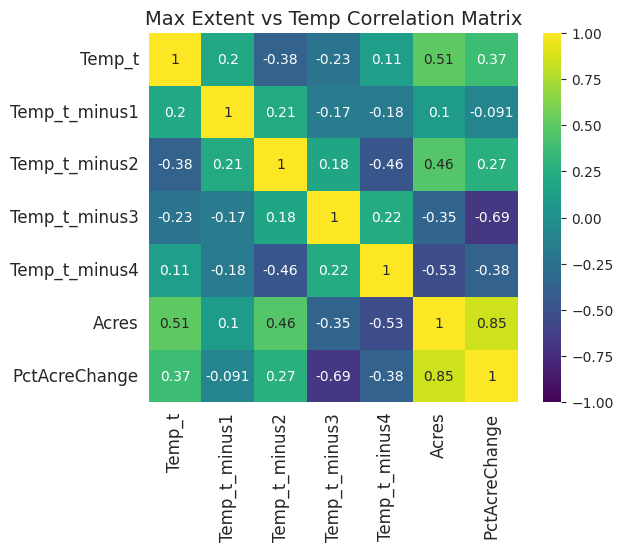

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
129,SHPT-W,15.0,9.0,2017.0,5.081829,12.000,12.649,12.649,12.649,12.649,NaN
130,SHPT-W,10.0,9.0,2018.0,9.818176,16.000,12.000,12.649,12.649,12.649,93.201636
131,SHPT-W,28.0,7.0,2019.0,4.414529,14.000,16.000,12.000,14.000,14.000,-55.037181
132,SHPT-W,18.0,9.0,2020.0,7.790410,11.400,14.000,16.000,12.000,12.649,76.472068
133,SHPT-W,19.0,9.0,2021.0,4.860296,10.695,11.400,14.000,16.000,12.000,-37.611814
134,SHPT-W,12.0,8.0,2022.0,3.267264,11.945,10.695,11.400,14.000,16.000,-32.776441
135,SHPT-W,1.0,9.0,2023.0,4.720687,13.150,11.945,10.695,11.400,14.000,44.484413
136,SHPT-W,16.0,8.0,2024.0,6.095017,12.200,13.150,11.945,10.695,11.400,29.112919


In [98]:
shannon_west_clean = corr_max(shannon_west)
shannon_west_clean

Strongest correlation was negative -0.69 for T minus 3

###Coffin Rocks

In [46]:
coffin_rocks = df_max[df_max['Site Code']== 'COFF']
coffin_rocks

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
30,Coffin Rocks,COFF,2016-09-26,26.0,1.0,9.0,2016.0,1.282635,11.0,NaN,...,NaN,NaN,NaN,11.00,NaN,11.566667,11.566667,11.566667,11.566667,11.566667
31,Coffin Rocks,COFF,2017-08-06,6.0,1.0,8.0,2017.0,1.281513,12.0,NaN,...,NaN,NaN,NaN,12.00,-0.087470,11.000000,12.211667,12.211667,12.211667,12.211667
32,Coffin Rocks,COFF,2018-08-10,10.0,1.0,8.0,2018.0,1.326819,13.0,NaN,...,NaN,NaN,NaN,13.00,3.535398,12.000000,11.000000,12.211667,12.211667,12.211667
33,Coffin Rocks,COFF,2019-09-25,25.0,1.0,9.0,2019.0,1.335530,12.0,NaN,...,NaN,NaN,NaN,12.00,0.656469,13.000000,12.000000,11.000000,11.566667,11.566667
34,Coffin Rocks,COFF,2020-08-17,17.0,1.0,8.0,2020.0,1.403082,NaN,12.20,...,NaN,12.20,13.00,12.60,5.058126,12.000000,13.000000,12.000000,11.000000,12.211667
35,Coffin Rocks,COFF,2021-08-05,5.0,1.0,8.0,2021.0,1.695371,NaN,12.00,...,NaN,12.00,13.00,12.50,20.831874,12.600000,12.000000,13.000000,12.000000,12.211667
36,Coffin Rocks,COFF,2022-08-25,25.0,1.0,8.0,2022.0,1.684242,NaN,11.67,...,NaN,11.67,11.67,11.67,-0.656423,12.500000,12.600000,12.000000,13.000000,12.211667
37,Coffin Rocks,COFF,2023-08-15,15.0,1.0,8.0,2023.0,1.621534,NaN,11.50,...,11.5,11.50,11.50,11.50,-3.723212,11.670000,12.500000,12.600000,12.000000,12.211667
38,Coffin Rocks,COFF,2024-09-16,16.0,1.0,9.0,2024.0,1.766295,NaN,11.70,...,11.7,11.70,11.70,11.70,8.927443,11.500000,11.670000,12.500000,12.600000,11.566667


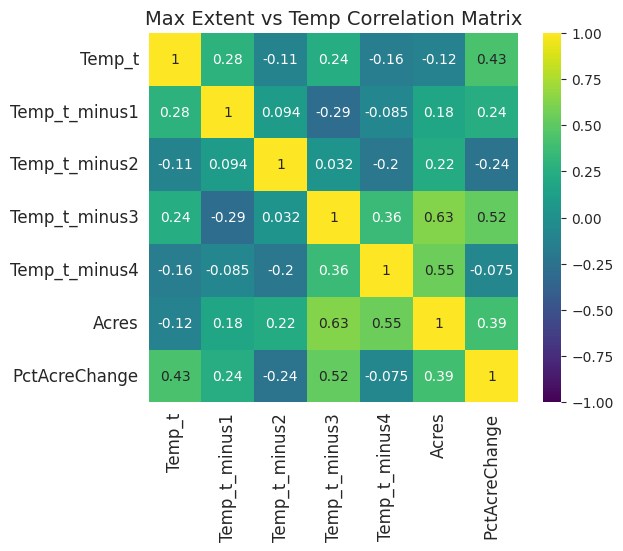

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
30,COFF,26.0,9.0,2016.0,1.282635,11.00,11.566667,11.566667,11.566667,11.566667,NaN
31,COFF,6.0,8.0,2017.0,1.281513,12.00,11.000000,12.211667,12.211667,12.211667,-0.087470
32,COFF,10.0,8.0,2018.0,1.326819,13.00,12.000000,11.000000,12.211667,12.211667,3.535398
33,COFF,25.0,9.0,2019.0,1.335530,12.00,13.000000,12.000000,11.000000,11.566667,0.656469
34,COFF,17.0,8.0,2020.0,1.403082,12.60,12.000000,13.000000,12.000000,11.000000,5.058126
35,COFF,5.0,8.0,2021.0,1.695371,12.50,12.600000,12.000000,13.000000,12.000000,20.831874
36,COFF,25.0,8.0,2022.0,1.684242,11.67,12.500000,12.600000,12.000000,13.000000,-0.656423
37,COFF,15.0,8.0,2023.0,1.621534,11.50,11.670000,12.500000,12.600000,12.000000,-3.723212
38,COFF,16.0,9.0,2024.0,1.766295,11.70,11.500000,11.670000,12.500000,12.600000,8.927443


In [105]:
coffin_rocks_clean = corr_max(coffin_rocks)
coffin_rocks_clean

Strongest correlation was temp t minus 3 at 0.52

###Lowell

In [48]:
lowell = df_max[df_max['Site Code']== 'LWLP']
lowell

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
88,Lowell,LWLP,2016-09-16,16.0,1.0,9.0,2016.0,18.081365,14.0,NaN,...,NaN,NaN,NaN,14.000000,NaN,13.683333,13.683333,13.683333,13.683333,13.683333
89,Lowell,LWLP,2017-08-23,23.0,1.0,8.0,2017.0,13.882558,NaN,NaN,...,NaN,NaN,NaN,17.216667,-23.221738,14.000000,17.216667,17.216667,17.216667,17.216667
90,Lowell,LWLP,2020-08-22,22.0,1.0,8.0,2020.0,5.854933,NaN,14.3,...,NaN,14.3,13.9,14.100000,-57.825256,17.216667,17.216667,17.216667,14.000000,17.216667
91,Lowell,LWLP,2021-09-19,19.0,1.0,9.0,2021.0,22.811846,NaN,14.4,...,NaN,14.4,12.7,13.550000,289.617533,14.100000,13.683333,13.683333,13.683333,13.683333
92,Lowell,LWLP,2022-08-12,12.0,1.0,8.0,2022.0,10.884915,NaN,17.8,...,NaN,17.8,17.8,17.800000,-52.283937,13.550000,14.100000,17.216667,17.216667,17.216667
93,Lowell,LWLP,2023-08-15,15.0,1.0,8.0,2023.0,19.738947,NaN,21.3,...,21.0,19.9,19.6,19.750000,81.342226,17.800000,13.550000,14.100000,17.216667,17.216667
94,Lowell,LWLP,2024-09-15,15.0,1.0,9.0,2024.0,24.889083,NaN,13.3,...,13.9,13.3,13.7,13.500000,26.091239,19.750000,17.800000,13.550000,14.100000,13.683333


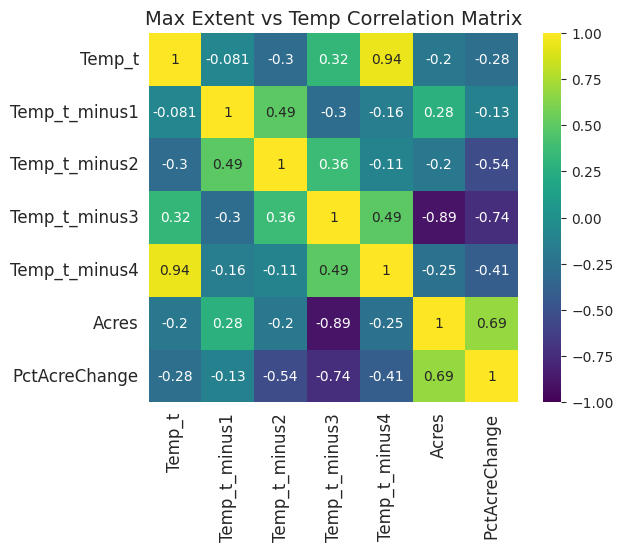

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
88,LWLP,16.0,9.0,2016.0,18.081365,14.000000,13.683333,13.683333,13.683333,13.683333,NaN
89,LWLP,23.0,8.0,2017.0,13.882558,17.216667,14.000000,17.216667,17.216667,17.216667,-23.221738
90,LWLP,22.0,8.0,2020.0,5.854933,14.100000,17.216667,17.216667,17.216667,14.000000,-57.825256
91,LWLP,19.0,9.0,2021.0,22.811846,13.550000,14.100000,13.683333,13.683333,13.683333,289.617533
92,LWLP,12.0,8.0,2022.0,10.884915,17.800000,13.550000,14.100000,17.216667,17.216667,-52.283937
93,LWLP,15.0,8.0,2023.0,19.738947,19.750000,17.800000,13.550000,14.100000,17.216667,81.342226
94,LWLP,15.0,9.0,2024.0,24.889083,13.500000,19.750000,17.800000,13.550000,14.100000,26.091239


In [109]:
lowell_clean = corr_max(lowell)
lowell_clean

Strongest correlation was -0.74 for temperature minus 3

#Analysis and Modeling (Linear Regression)

In [27]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns
# set the plotting style
sns.set_style("whitegrid")

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

##Polnell Point

###Plots

####Temp vs Acres

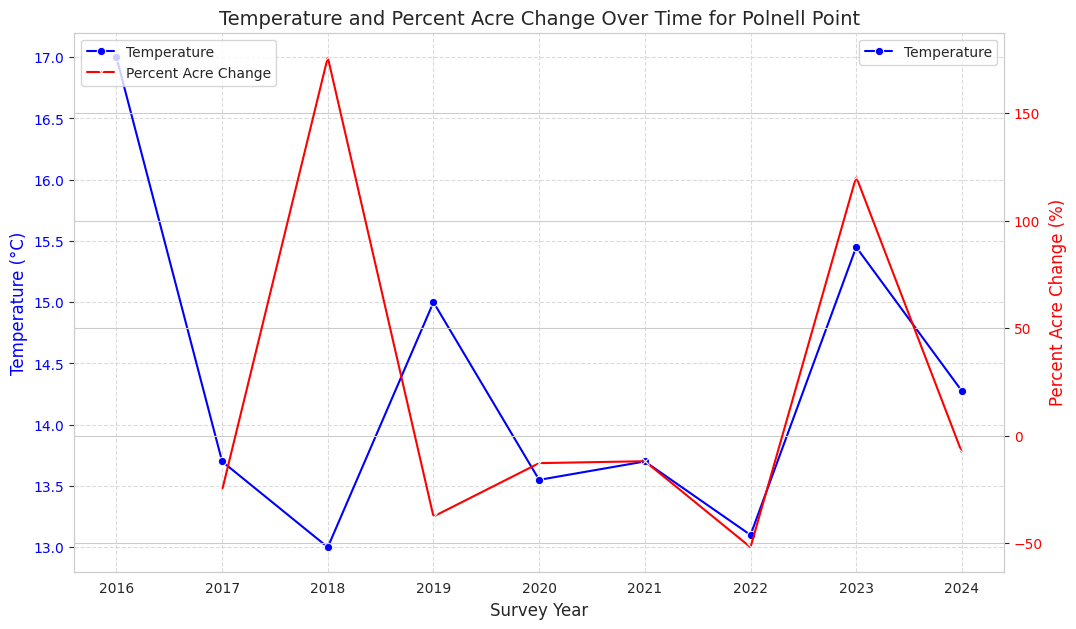

In [85]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=polnell_clean, x='Survey Year', y='Temp_t', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=polnell_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature and Percent Acre Change Over Time for Polnell Point', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

####Temp minus 2

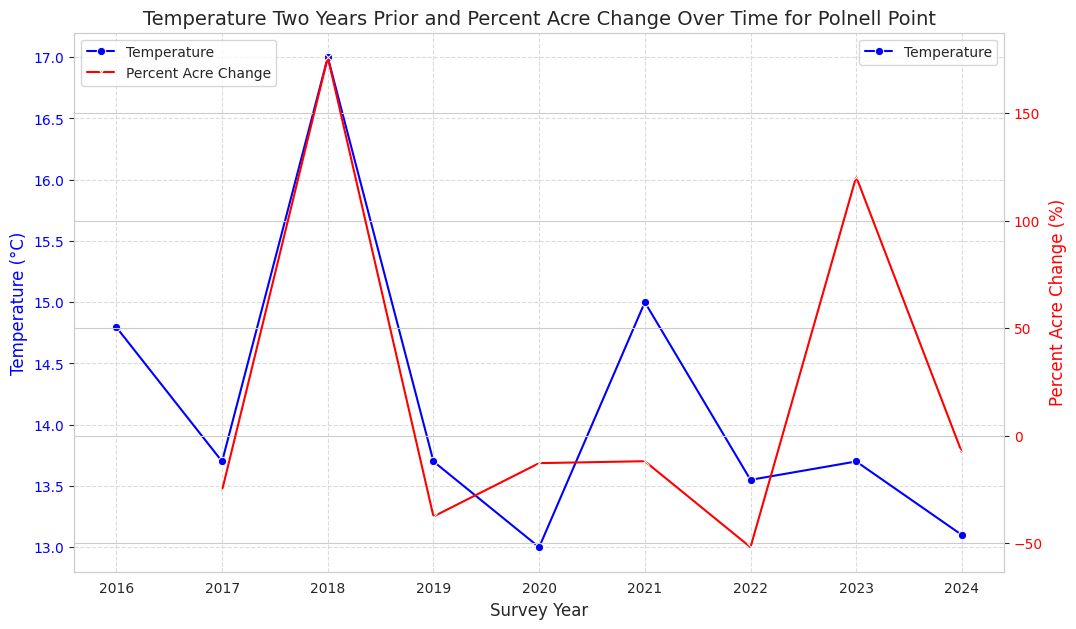

In [83]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=polnell_clean, x='Survey Year', y='Temp_t_minus2', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=polnell, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Two Years Prior and Percent Acre Change Over Time for Polnell Point', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

####Regressions

#####Multiple

In [30]:
model_polnell_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=polnell).fit()

In [31]:
print(model_polnell_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.9524
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.584
Time:                        00:05:31   Log-Likelihood:                -41.258
No. Observations:                   8   AIC:                             94.52
Df Residuals:                       2   BIC:                             94.99
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1294.8376   1701.104     -0.761

Acres

In [32]:
model_polnell_multiple_acre = smf.ols(formula='Acres ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=polnell).fit()

In [33]:
print(model_polnell_multiple_acre.summary())

                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.095
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.502
Time:                        00:05:31   Log-Likelihood:                -32.489
No. Observations:                   9   AIC:                             76.98
Df Residuals:                       3   BIC:                             78.16
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -195.0458    197.835     -0.986

####Single

In [113]:
model_polnell_single = smf.ols(formula='PctAcreChange ~ Temp_t_minus2', data=polnell_clean).fit()

In [114]:
print(model_polnell_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     5.483
Date:                Wed, 10 Dec 2025   Prob (F-statistic):             0.0577
Time:                        01:35:55   Log-Likelihood:                -43.534
No. Observations:                   8   AIC:                             91.07
Df Residuals:                       6   BIC:                             91.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -590.4012    261.115     -2.261

Lower R squared value!

In [115]:
model_polnell_single.rsquared

np.float64(0.4775011185988788)

In [116]:
y_hat = model_polnell_single.predict()

In [119]:
np.sqrt(mean_squared_error(polnell_clean['PctAcreChange'].dropna(), y_hat)).round(3)

np.float64(55.856)

In [120]:
mean_absolute_error(polnell_clean['PctAcreChange'].dropna(), y_hat)

45.71292675205149

##Ebey

####Plots

####Temp minus 2

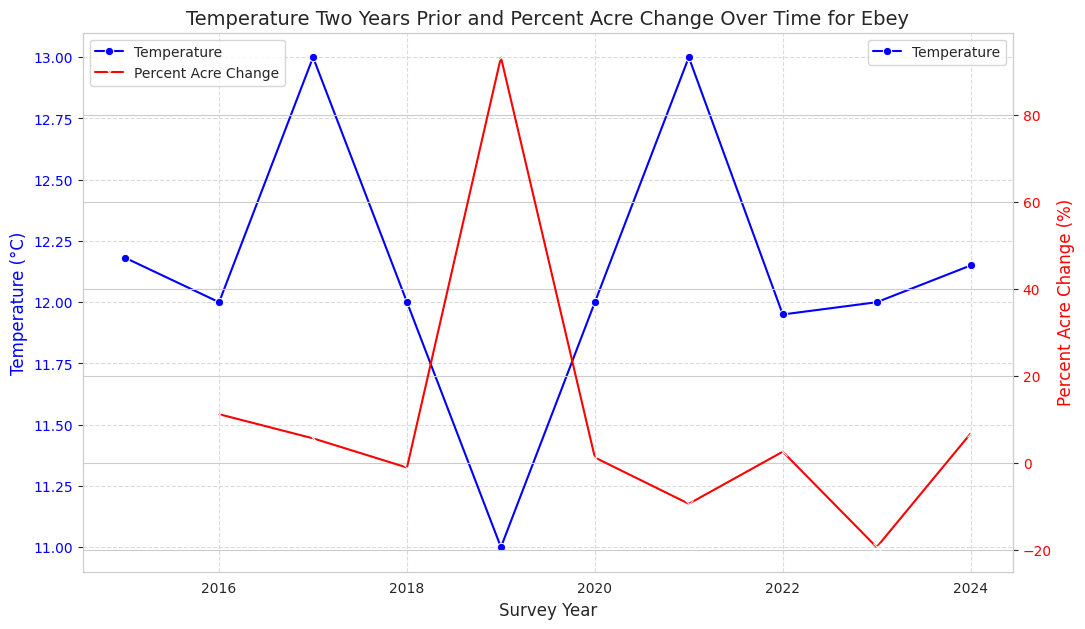

In [86]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=ebey_clean, x='Survey Year', y='Temp_t_minus2', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=ebey_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Two Years Prior and Percent Acre Change Over Time for Ebey', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [78]:
model_ebey_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=ebey_clean).fit()

In [79]:
print(model_ebey_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     3.410
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.171
Time:                        01:08:53   Log-Likelihood:                -35.023
No. Observations:                   9   AIC:                             82.05
Df Residuals:                       3   BIC:                             83.23
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1899.1364    834.455      2.276

####Single

In [121]:
model_ebey_single = smf.ols(formula='PctAcreChange ~ Temp_t_minus2', data=ebey_clean).fit()

In [122]:
print(model_ebey_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     6.217
Date:                Wed, 10 Dec 2025   Prob (F-statistic):             0.0414
Time:                        01:51:15   Log-Likelihood:                -40.712
No. Observations:                   9   AIC:                             85.42
Df Residuals:                       7   BIC:                             85.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       459.5469    180.481      2.546

##Hoypus

###Plots

####Temp minus 3

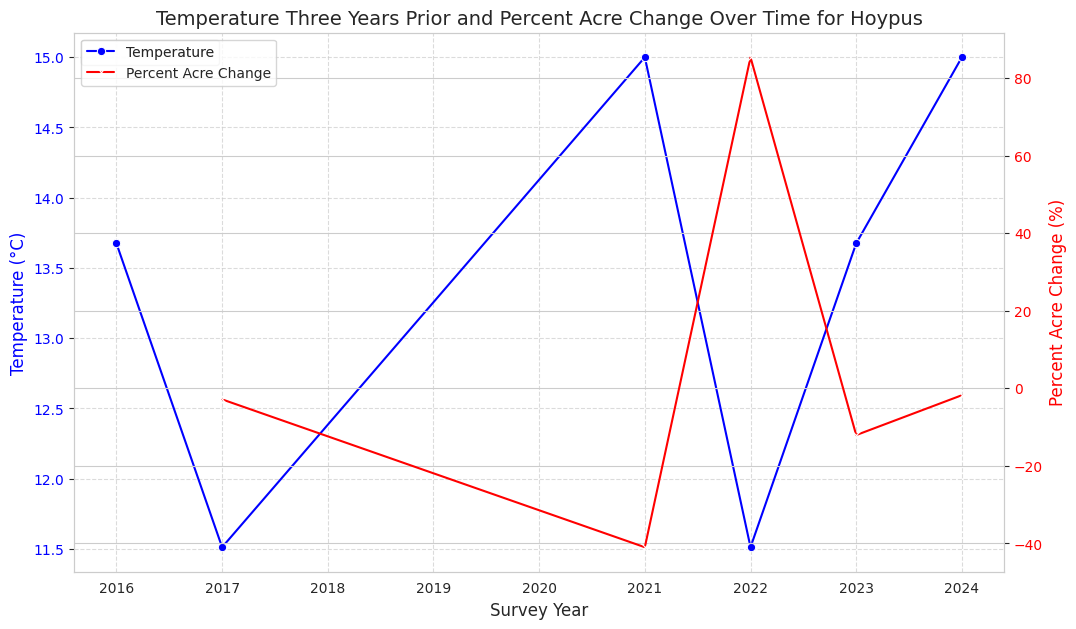

In [93]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=hoypus_clean, x='Survey Year', y='Temp_t_minus3', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=hoypus_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Three Years Prior and Percent Acre Change Over Time for Hoypus', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

####Temp Minus 2

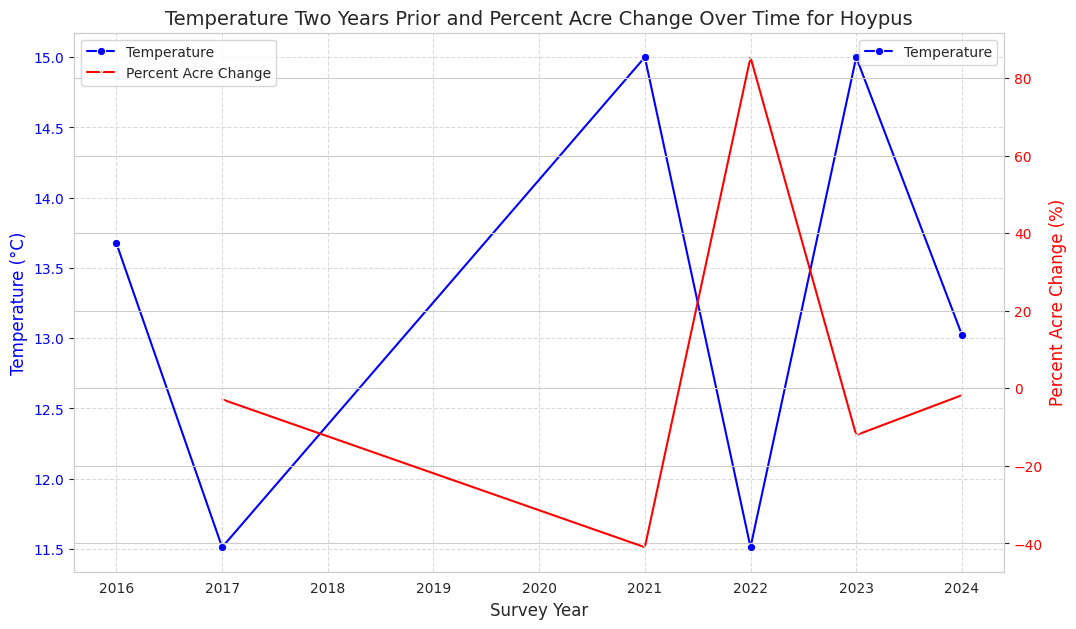

In [94]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=hoypus_clean, x='Survey Year', y='Temp_t_minus2', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=hoypus_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Two Years Prior and Percent Acre Change Over Time for Hoypus', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [95]:
model_hoypus_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=hoypus_clean).fit()

In [96]:
print(model_hoypus_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 10 Dec 2025   Prob (F-statistic):                nan
Time:                        01:15:37   Log-Likelihood:                 145.94
No. Observations:                   5   AIC:                            -281.9
Df Residuals:                       0   BIC:                            -283.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5081        inf         -0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


##Shannon Point East

###Plots

####Temp t

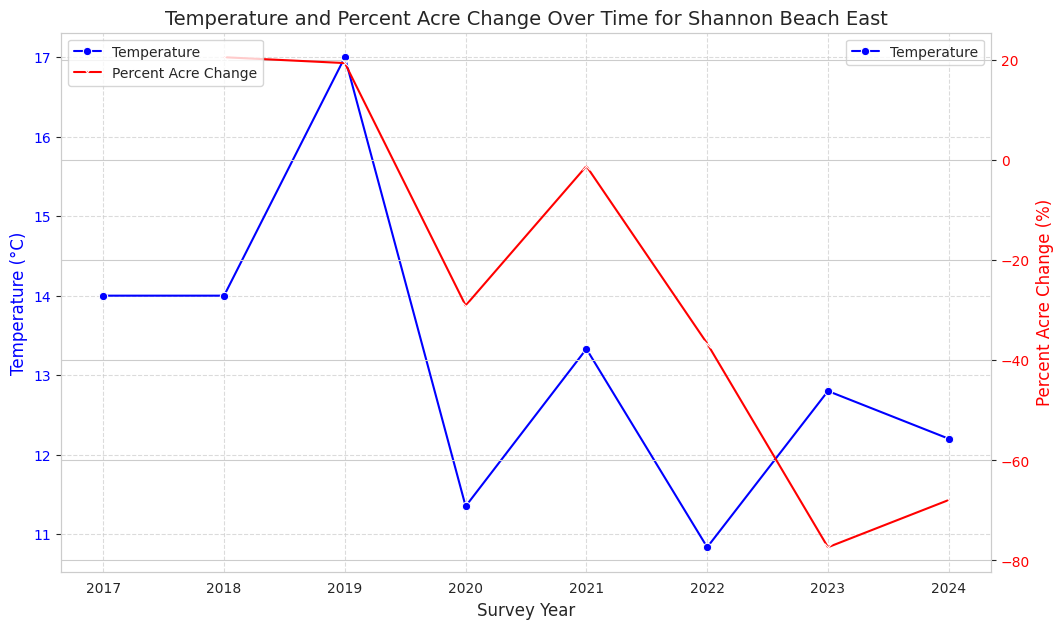

In [99]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=shannon_east_clean, x='Survey Year', y='Temp_t', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=shannon_east_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature and Percent Acre Change Over Time for Shannon Beach East', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [100]:
model_shannon_east_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=shannon_east_clean).fit()

In [101]:
print(model_shannon_east_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                 -0.160
Method:                 Least Squares   F-statistic:                    0.8344
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.676
Time:                        01:18:18   Log-Likelihood:                -29.374
No. Observations:                   7   AIC:                             70.75
Df Residuals:                       1   BIC:                             70.42
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -442.8390    352.695     -1.256

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


####Single

In [123]:
model_shannon_east_single = smf.ols(formula='PctAcreChange ~ Temp_t', data=shannon_east_clean).fit()

In [124]:
print(model_shannon_east_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     3.363
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.126
Time:                        01:53:41   Log-Likelihood:                -33.325
No. Observations:                   7   AIC:                             70.65
Df Residuals:                       5   BIC:                             70.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -184.4447     88.090     -2.094      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


##Shannon Point West

###Plots

####Temp minus 3

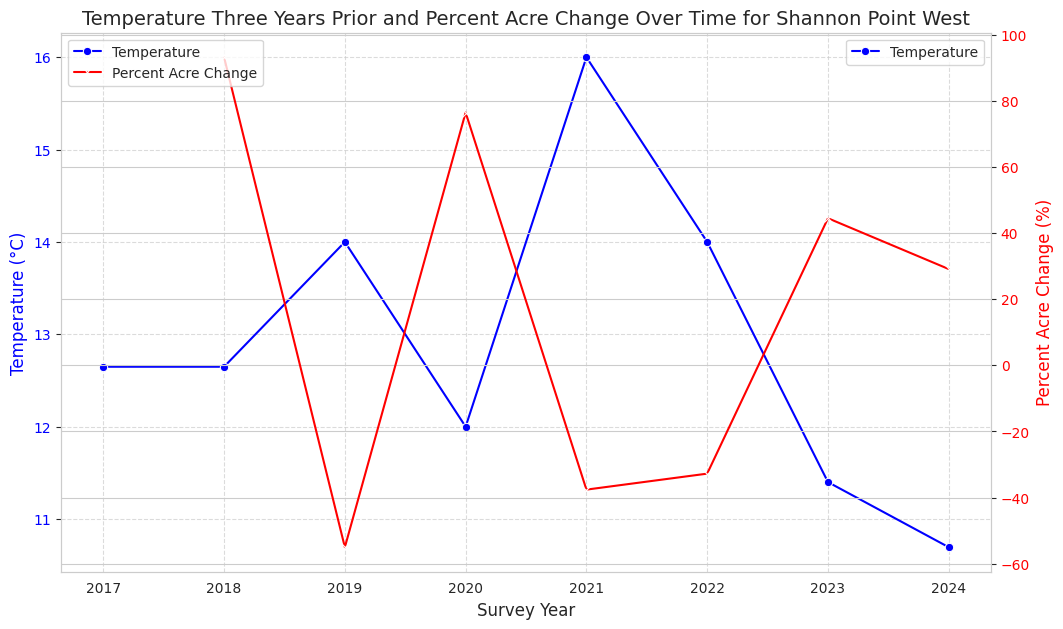

In [102]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=shannon_west_clean, x='Survey Year', y='Temp_t_minus3', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=shannon_west_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Three Years Prior and Percent Acre Change Over Time for Shannon Point West', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [103]:
model_shannon_west_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=shannon_west_clean).fit()

In [104]:
print(model_shannon_west_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     7.851
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.264
Time:                        01:18:54   Log-Likelihood:                -25.004
No. Observations:                   7   AIC:                             62.01
Df Residuals:                       1   BIC:                             61.68
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        15.3487    188.754      0.081

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


####Single

In [125]:
model_shannon_west_single = smf.ols(formula='PctAcreChange ~ Temp_t_minus3', data=shannon_west_clean).fit()

In [126]:
print(model_shannon_west_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     4.463
Date:                Wed, 10 Dec 2025   Prob (F-statistic):             0.0883
Time:                        01:54:54   Log-Likelihood:                -35.704
No. Observations:                   7   AIC:                             75.41
Df Residuals:                       5   BIC:                             75.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       304.6862    137.408      2.217

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


##Possession Point

###Plots

####Temp T-2

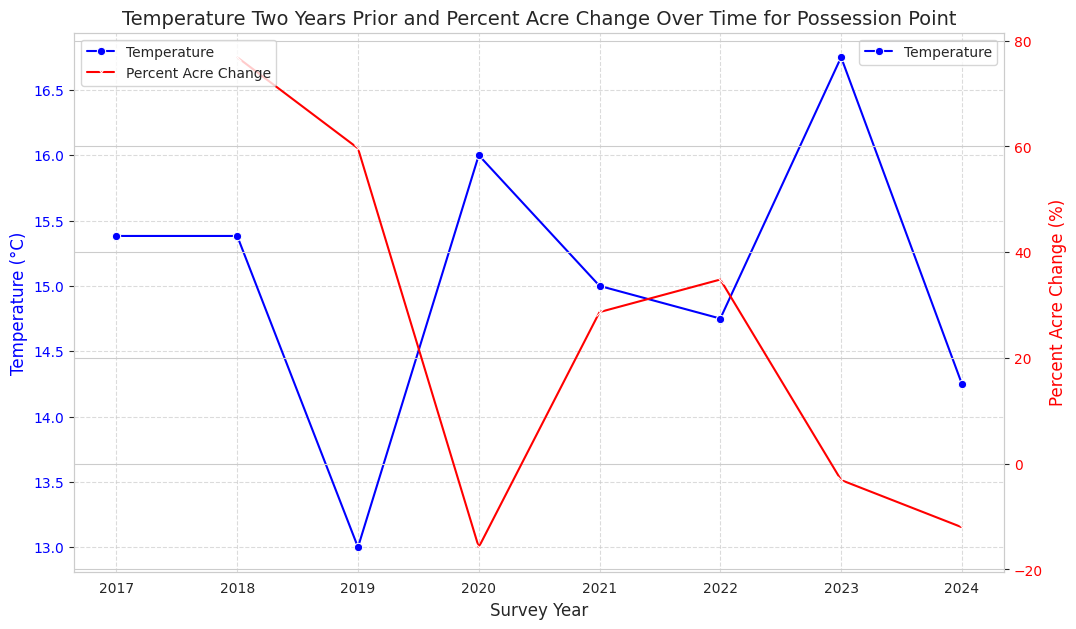

In [87]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=possession_clean, x='Survey Year', y='Temp_t_minus2', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=possession_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Two Years Prior and Percent Acre Change Over Time for Possession Point', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [134]:
model_possession_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=possession_clean).fit()

In [135]:
print(model_possession_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.043
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.628
Time:                        02:13:19   Log-Likelihood:                -28.103
No. Observations:                   7   AIC:                             68.21
Df Residuals:                       1   BIC:                             67.88
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       488.1908    801.600      0.609

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


####Single

In [127]:
model_possession_single = smf.ols(formula='PctAcreChange ~ Temp_t_minus2', data=possession_clean).fit()

In [128]:
print(model_possession_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.159
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.331
Time:                        01:56:39   Log-Likelihood:                -33.768
No. Observations:                   7   AIC:                             71.54
Df Residuals:                       5   BIC:                             71.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       218.0800    180.602      1.208

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


##North Beach

###Plots

####Temp T minus 1

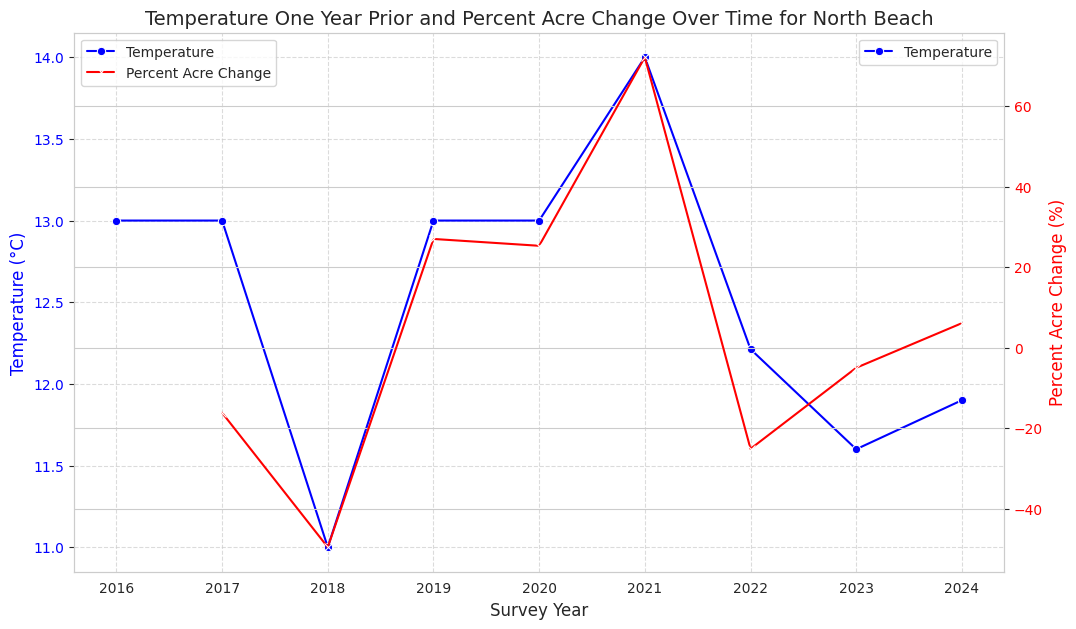

In [89]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=north_clean, x='Survey Year', y='Temp_t_minus1', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=north_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature One Year Prior and Percent Acre Change Over Time for North Beach', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [90]:
model_north_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=north_clean).fit()

In [91]:
print(model_north_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     2.306
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.330
Time:                        01:12:44   Log-Likelihood:                -32.169
No. Observations:                   8   AIC:                             76.34
Df Residuals:                       2   BIC:                             76.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -815.9012    355.388     -2.296

####Single

#####Temp t minus 1

In [139]:
model_north_single = smf.ols(formula='PctAcreChange ~ Temp_t_minus1', data=north_clean).fit()

In [140]:
print(model_north_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     13.37
Date:                Wed, 10 Dec 2025   Prob (F-statistic):             0.0106
Time:                        02:19:57   Log-Likelihood:                -35.128
No. Observations:                   8   AIC:                             74.26
Df Residuals:                       6   BIC:                             74.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -399.1161    110.620     -3.608

##Lowell

###Plots

####Temperature minus 3

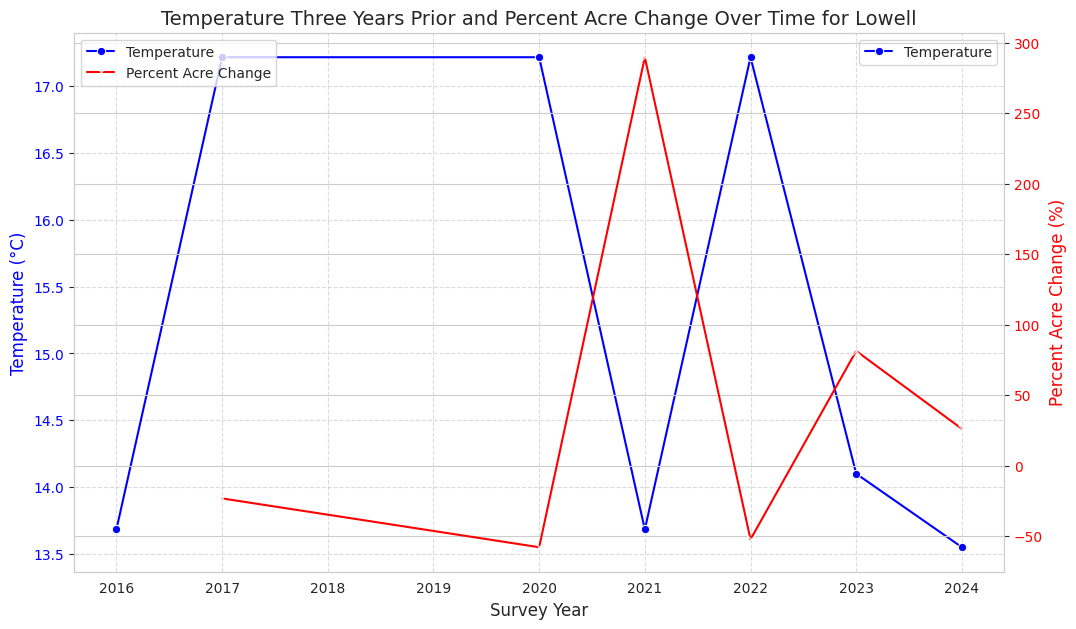

In [110]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=lowell_clean, x='Survey Year', y='Temp_t_minus3', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=lowell_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Three Years Prior and Percent Acre Change Over Time for Lowell', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [111]:
model_lowell_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=lowell_clean).fit()

In [112]:
print(model_lowell_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 10 Dec 2025   Prob (F-statistic):                nan
Time:                        01:21:09   Log-Likelihood:                 153.79
No. Observations:                   6   AIC:                            -295.6
Df Residuals:                       0   BIC:                            -296.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2473.0754        inf          0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


##Coffin Rocks

###Plots

####Temp T minus 3

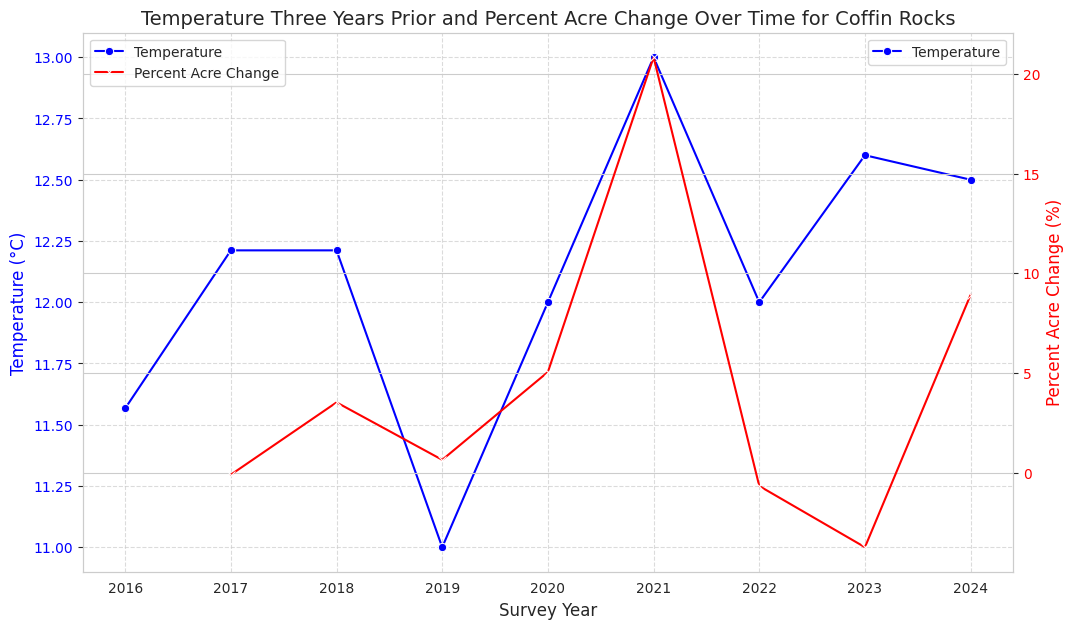

In [106]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Temp_t on the first y-axis
sns.lineplot(data=coffin_rocks_clean, x='Survey Year', y='Temp_t_minus3', marker='o', ax=ax1, color='blue', label='Temperature')
ax1.set_xlabel('Survey Year', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot PctAcreChange on the second y-axis
sns.lineplot(data=coffin_rocks_clean, x='Survey Year', y='PctAcreChange', marker='x', ax=ax2, color='red', label='Percent Acre Change')
ax2.set_ylabel('Percent Acre Change (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Temperature Three Years Prior and Percent Acre Change Over Time for Coffin Rocks', fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

###Regressions

####Multiple

In [107]:
model_coff_multiple = smf.ols(formula='PctAcreChange ~ + Temp_t + Temp_t_minus1 + Temp_t_minus2 + Temp_t_minus3 + Temp_t_minus4', data=coffin_rocks_clean).fit()

In [108]:
print(model_coff_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                 -0.228
Method:                 Least Squares   F-statistic:                    0.7400
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.661
Time:                        01:19:59   Log-Likelihood:                -22.980
No. Observations:                   8   AIC:                             57.96
Df Residuals:                       2   BIC:                             58.44
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -158.9189    244.961     -0.649

####Single

In [142]:
model_coffin_single = smf.ols(formula='PctAcreChange ~ Temp_t_minus3', data=coffin_rocks_clean).fit()

In [143]:
print(model_coffin_single.summary())

                            OLS Regression Results                            
Dep. Variable:          PctAcreChange   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2.249
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.184
Time:                        02:20:34   Log-Likelihood:                -25.896
No. Observations:                   8   AIC:                             55.79
Df Residuals:                       6   BIC:                             55.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -79.4510     55.916     -1.421

#Conclusions

The correlation matrices and line plots for each of the nine beds led to different temperature predictor variables. Although there were strong correlation variables (whether negative or positive), none of the multiple regression models were statistically significant. Only one of the single predictor models was statistically significant at North Beach for Temp_T_minus1.


(Explain why North Beach may be more significant)



This implies there is likely another third variable or a combination of the variables that have an impact on kelp growth rate.

Assess further:


1.   Polnell
2.   Shannon Beach East
3. Shannon Beach West
4. North Beach
5. Possession Point
6. Coffin Rocks




##Table

###Multiple

In [138]:
import pandas as pd
import numpy as np

def extract_model_metrics(model, bed_name):
    """
    Extracts key metrics from an OLS regression model summary.
    """
    metrics = {
        "Bed Name": bed_name,
        "R-squared": None,
        "Best Predictor": None,
        "Coefficient": None,
        "P-value": None,
        "Notes": ""
    }

    if model.rsquared is None or np.isnan(model.rsquared):
        metrics["R-squared"] = "N/A"
        metrics["Notes"] = "Model unreliable due to insufficient data or singularity."
        return metrics

    metrics["R-squared"] = round(model.rsquared, 3)

    # Exclude intercept from predictors
    predictor_pvalues = model.pvalues.drop("Intercept", errors='ignore')
    predictor_coefficients = model.params.drop("Intercept", errors='ignore')

    if not predictor_pvalues.empty:
        # Filter out NaN p-values which might indicate issues
        valid_pvalues = predictor_pvalues.dropna()
        if not valid_pvalues.empty:
            min_p_value = valid_pvalues.min()
            best_predictor = valid_pvalues.idxmin()

            # Ensure the best_predictor's coefficient is not inf or nan
            best_coef = predictor_coefficients.get(best_predictor)
            if best_coef is not None and not np.isinf(best_coef) and not np.isnan(best_coef):
                metrics["Best Predictor"] = best_predictor
                metrics["Coefficient"] = round(best_coef, 3)
                metrics["P-value"] = round(min_p_value, 3)
                if min_p_value > 0.05:
                    metrics["Notes"] = "No statistically significant predictor at p<0.05."
            else:
                metrics["Notes"] = "Best predictor's coefficient was invalid (NaN/Inf)."
        else:
            metrics["Notes"] = "No valid p-values for predictors."
    else:
        metrics["Notes"] = "No predictors found (only intercept or no data)."

    # Check for general model issues
    if "Cond. No." in str(model.summary2()) and "e+0" in str(model.summary2()):
         if "multicollinearity" not in metrics["Notes"]:
            metrics["Notes"] = (metrics["Notes"] + " High multicollinearity suspected." if metrics["Notes"] else "High multicollinearity suspected.")

    return metrics

# List of models and their corresponding bed names
models_to_analyze = [
    (model_polnell_multiple, "Polnell Point"),
    (model_shannon_east_multiple, "Shannon Point East"),
    (model_shannon_west_multiple, "Shannon Point West"),
    (model_north_multiple, "North Beach"),
    (model_possesion_multiple, "Possession Point"),
    (model_coff_multiple, "Coffin Rocks"),
    (model_hoypus_multiple, "Hoypus Point"),
    (model_lowell_multiple, "Lowell")
]

results = []
for model, bed_name in models_to_analyze:
    results.append(extract_model_metrics(model, bed_name))

# Convert results to DataFrame
summary_df = pd.DataFrame(results)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/

In [137]:
display(summary_df)

,Bed Name,R-squared,Best Predictor,Coefficient,P-value,Notes
0,Polnell Point,0.704,Temp_t_minus2,53.060,0.276,No statistically significant predictor at p<0.05.
1,Shannon Point East,0.807,Temp_t,12.599,0.413,No statistically significant predictor at p<0.05.
2,Shannon Point West,0.975,Temp_t_minus3,-24.600,0.144,No statistically significant predictor at p<0.05.
3,North Beach,0.852,Temp_t_minus1,41.389,0.106,No statistically significant predictor at p<0.05.
4,Possession Point,0.839,Temp_t_minus1,-25.114,0.367,No statistically significant predictor at p<0.05.
5,Coffin Rocks,0.649,Temp_t_minus3,10.102,0.263,No statistically significant predictor at p<0.05.
6,Hoypus Point,1.000,None,NaN,NaN,No valid p-values for predictors.
7,Lowell,1.000,None,NaN,NaN,No valid p-values for predictors.


###Single

In [148]:
import pandas as pd
import numpy as np

def extract_model_metrics(model, bed_name):
    """
    Extracts key metrics from an OLS regression model summary.
    """
    metrics = {
        "Bed Name": bed_name,
        "R-squared": None,
        "Best Predictor": None,
        "Coefficient": None,
        "P-value": None,
        "Notes": ""
    }

    if model.rsquared is None or np.isnan(model.rsquared):
        metrics["R-squared"] = "N/A"
        metrics["Notes"] = "Model unreliable due to insufficient data or singularity."
        return metrics

    metrics["R-squared"] = round(model.rsquared, 3)

    # Exclude intercept from predictors
    predictor_pvalues = model.pvalues.drop("Intercept", errors='ignore')
    predictor_coefficients = model.params.drop("Intercept", errors='ignore')

    if not predictor_pvalues.empty:
        # Filter out NaN p-values which might indicate issues
        valid_pvalues = predictor_pvalues.dropna()
        if not valid_pvalues.empty:
            min_p_value = valid_pvalues.min()
            best_predictor = valid_pvalues.idxmin()

            # Ensure the best_predictor's coefficient is not inf or nan
            best_coef = predictor_coefficients.get(best_predictor)
            if best_coef is not None and not np.isinf(best_coef) and not np.isnan(best_coef):
                metrics["Best Predictor"] = best_predictor
                metrics["Coefficient"] = round(best_coef, 3)
                metrics["P-value"] = round(min_p_value, 3)
                if min_p_value > 0.05:
                    metrics["Notes"] = "No statistically significant predictor at p<0.05."
            else:
                metrics["Notes"] = "Best predictor's coefficient was invalid (NaN/Inf)."
        else:
            metrics["Notes"] = "No valid p-values for predictors."
    else:
        metrics["Notes"] = "No predictors found (only intercept or no data)."

    # Check for general model issues
    if "Cond. No." in str(model.summary2()) and "e+0" in str(model.summary2()):
         if "multicollinearity" not in metrics["Notes"]:
            metrics["Notes"] = (metrics["Notes"] + " High multicollinearity suspected." if metrics["Notes"] else "High multicollinearity suspected.")

    return metrics

# List of models and their corresponding bed names
models_to_analyze = [
    (model_polnell_single, "Polnell Point"),
    (model_shannon_east_single, "Shannon Point East"),
    (model_shannon_west_single, "Shannon Point West"),
    (model_north_single, "North Beach"),
    (model_possession_single, "Possession Point"),
    (model_coffin_single, "Coffin Rocks")
]

results = []
for model, bed_name in models_to_analyze:
    results.append(extract_model_metrics(model, bed_name))

# Convert results to DataFrame
summary_df_single = pd.DataFrame(results)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [149]:
display(summary_df_single)

,Bed Name,R-squared,Best Predictor,Coefficient,P-value,Notes
0,Polnell Point,0.478,Temp_t_minus2,43.218,0.058,No statistically significant predictor at p<0.05.
1,Shannon Point East,0.402,Temp_t,12.228,0.126,No statistically significant predictor at p<0.05.
2,Shannon Point West,0.472,Temp_t_minus3,-22.205,0.088,No statistically significant predictor at p<0.05.
3,North Beach,0.690,Temp_t_minus1,32.370,0.011,
4,Possession Point,0.188,Temp_t_minus2,-12.912,0.331,No statistically significant predictor at p<0.05.
5,Coffin Rocks,0.273,Temp_t_minus3,6.872,0.184,No statistically significant predictor at p<0.05.
